In [7]:
# Standard Libraries
import math
from sklearn.utils import resample
import pickle
import warnings
# Scientific Computing and Data Manipulation
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.spatial.distance import mahalanobis

# Machine Learning Models and Utilities
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.decomposition import PCA
from sklearn.ensemble import (
    IsolationForest,
    RandomForestClassifier,
    StackingClassifier,
    VotingClassifier
)
from sklearn.experimental import enable_halving_search_cv
from sklearn.feature_selection import RFE, SelectFromModel, mutual_info_classif
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    average_precision_score,
    balanced_accuracy_score,
    brier_score_loss,
    classification_report,
    confusion_matrix,
    f1_score,
    log_loss,
    matthews_corrcoef,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    auc
)
from sklearn.model_selection import (
    GridSearchCV,
    HalvingRandomSearchCV,
    RandomizedSearchCV,
    RepeatedStratifiedKFold,
    cross_val_score,
    learning_curve,
    train_test_split
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, label_binarize
from sklearn.svm import OneClassSVM
from sklearn.tree import DecisionTreeClassifier, plot_tree

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Imbalanced Learning
import imblearn
from imblearn.over_sampling import SMOTE

# Parallelization
from joblib import Parallel, delayed

# Google Colab Utilities
from google.colab import drive, files

# Warnings
warnings.filterwarnings('ignore')

# Google Drive Mount
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
#%store -r xgb_model
with open('/content/drive/My Drive/IEEE_dataset/xgb_model.pkl', 'rb') as f:
    xgb_model = pickle.load(f)
#%store -r filtered_trainDF
filtered_trainDF = pd.read_pickle('/content/drive/My Drive/IEEE_dataset/filtered_trainDF.pkl')
#%store -r testDF
testDF = pd.read_pickle('/content/drive/My Drive/IEEE_dataset/testDF.pkl')

In [9]:
X = filtered_trainDF.drop(columns=['isFraud'])  # Features
y = filtered_trainDF['isFraud']  # Target

for col in X.columns:
    if X[col].dtype == 'datetime64[ns]' or 'Timestamp' in col:
        X[col] = pd.to_datetime(X[col], errors='coerce').astype('int64')  # Convert to timestamp (int)

label_encoders = {}
for col in X.columns:
    if X[col].dtype == 'object' or isinstance(X[col].dtype, pd.CategoricalDtype):
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le

X.replace([np.inf, -np.inf], np.nan, inplace=True)
X = X.apply(pd.to_numeric, errors='coerce')  # Convert all columns to numeric, setting problematic entries to NaN

for col in X.columns:
    if X[col].dtype in ['float64', 'int64']:
        X[col] = X[col].fillna(X[col].mean())  # Numeric columns: fill with mean
    else:
        X[col] = X[col].fillna(X[col].mode()[0])  # Non-numeric columns: fill with mode

print(X.dtypes)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

TransactionID               int64
TransactionDT               int64
TransactionAmt            float64
ProductCD                   int64
card1                       int64
                           ...   
Amt_To_Week_Ratio         float64
Card_Transaction_Mean     float64
Card_Transaction_Std      float64
Card_Transaction_Count      int64
card4_freq                float64
Length: 449, dtype: object
X_train shape: (423092, 449)
y_train shape: (423092,)


# 3) Modeling (Continued)

After creating both a CART model and an XGBoost model to detect fraud in our dataset, we found that the XGBoost model significantly outperforms the CART model. Because of that, we focused on trying to improve the XGBoost model's performance using a variety of methods, including Grid Search to detect the best estimators, hyperparameter combination analysis, and using only the top 10 features in a revised XGBoost model. We eventually settled on the use of a weighted ensembler to combine the predictive abilities of XGBoost, Random Forest, and Logistic Regression.

# ----------------------------------------------------------------------------------

# Grid Search Best Estimator Analysis (Don't Run)


In [10]:
param_grid = {
    'n_estimators': [1, 3, 5],
    'max_depth': [1, 2, 3],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0]
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

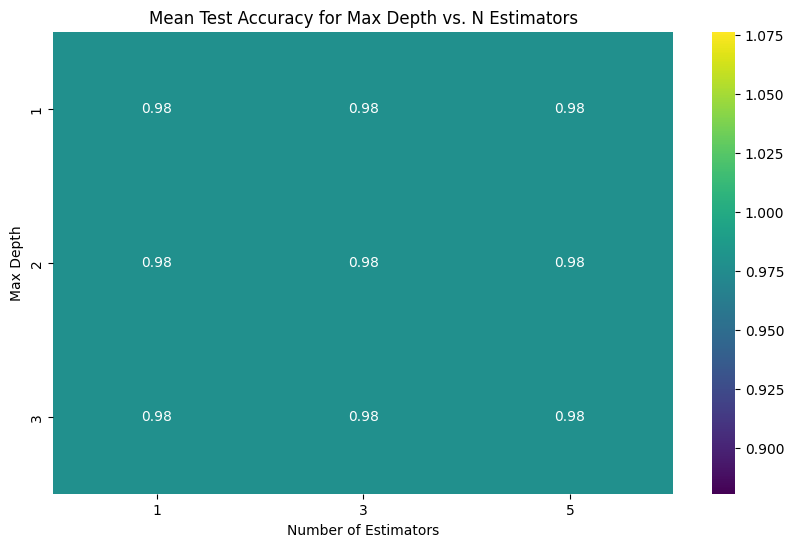

In [11]:
results_df = pd.DataFrame(grid_search.cv_results_)

# Pivot the data for a heatmap (example for 'max_depth' vs 'n_estimators')
pivot_table = results_df.pivot_table(values='mean_test_score',
                                     index='param_max_depth',
                                     columns='param_n_estimators')

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='viridis')
plt.title('Mean Test Accuracy for Max Depth vs. N Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Max Depth')
plt.show()

<p style="font-size:10px"> Our first attempt to improve XGBoost's performance was to use grid search to look for the best max depth and number of estimators for the XGBoost tree. We found that all combinations of maximum depths and numbers of estimators from 1 to around 100 resulted in an accuracy of around 0.98. </p>

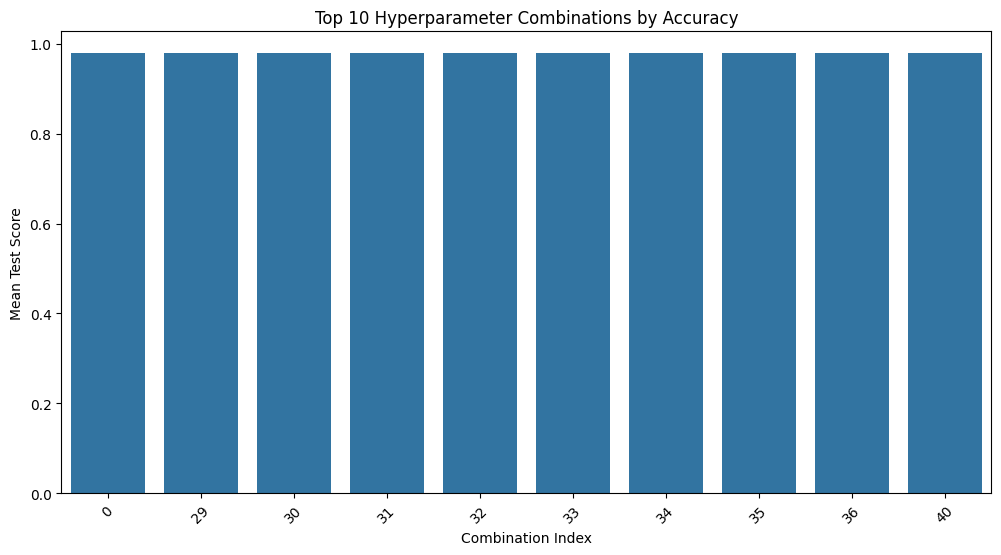

In [12]:
top_results = results_df.sort_values(by='mean_test_score', ascending=False).head(10)

# Plot a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=top_results.index, y=top_results['mean_test_score'])
plt.title('Top 10 Hyperparameter Combinations by Accuracy')
plt.ylabel('Mean Test Score')
plt.xlabel('Combination Index')
plt.xticks(rotation=45)
plt.show()

<p style="font-size:10px"> We next attempted to improve XGBoost's performance by trying different hyperparameter value combinations. We again found all the hyperparameter combinations we tried resulted in an accuracy of around 0.98. </p>

# ----------------------------------------------------------------------------------

# Top 10 Features Analysis (Don't Run)

In [13]:
top_n = 10
feature_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
top_features = feature_importances.sort_values(ascending=False).head(top_n).index

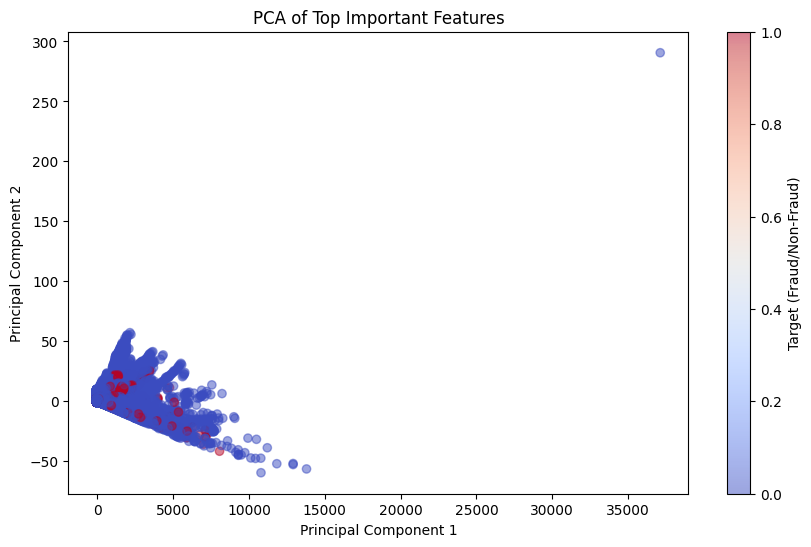

In [14]:
X_reduced = X[top_features]
pca = PCA(n_components=2)  # Change the number of components as needed
X_pca = pca.fit_transform(X_reduced)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Top Important Features')
plt.colorbar(label='Target (Fraud/Non-Fraud)')
plt.show()

In [15]:
X_train_top_features = X_train[top_features]
X_test_top_features = X_test[top_features]
grid_search_top_features = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search_top_features.fit(X_train_top_features, y_train)

best_model_top_features = grid_search_top_features.best_estimator_
y_pred = best_model_top_features.predict(X_test_top_features)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the tuned model using top 10 features: {accuracy:.4f}")

Accuracy of the tuned model using top 10 features: 0.9787


<p style="font-size:10px"> We also tried training the model on only the top 10 features, but found that the resulting accuracy was similar to the performance with the full dataset. A 2D PCA visualization using the top 10 features (above) showed that fraudulent transactions had a similar distribution of values among the two principle components as non-fraudulent transactions. </p>

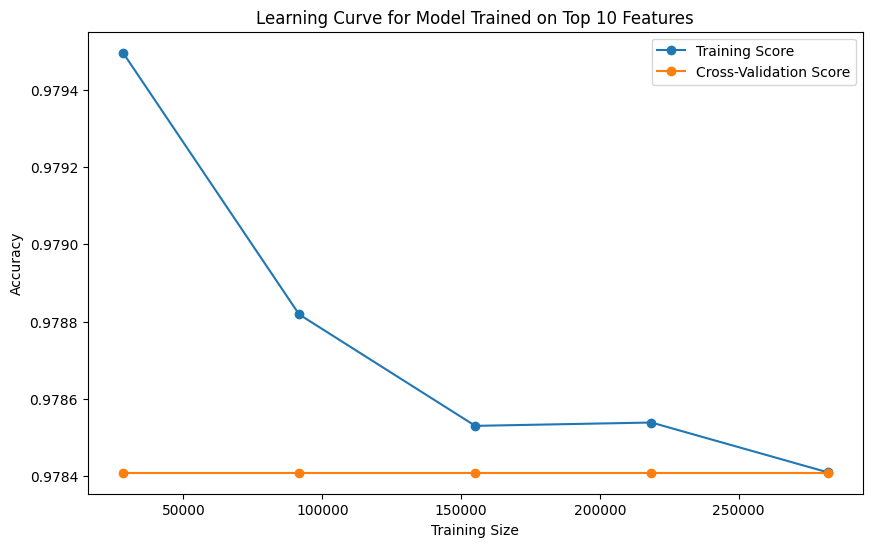

In [16]:
train_sizes, train_scores, test_scores = learning_curve(best_model_top_features,
                                                        X_train_top_features,
                                                        y_train, cv=3, scoring='accuracy',
                                                        train_sizes=np.linspace(0.1, 1.0, 5))

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label='Training Score')
plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', label='Cross-Validation Score')
plt.title('Learning Curve for Model Trained on Top 10 Features')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

<p style="font-size:10px"> The learning curve for the model trained on the top 10 features also indicated that accuracy remained roughly constant as training size increased. </p>

Accuracy of XGBoost on combined data: 0.9790


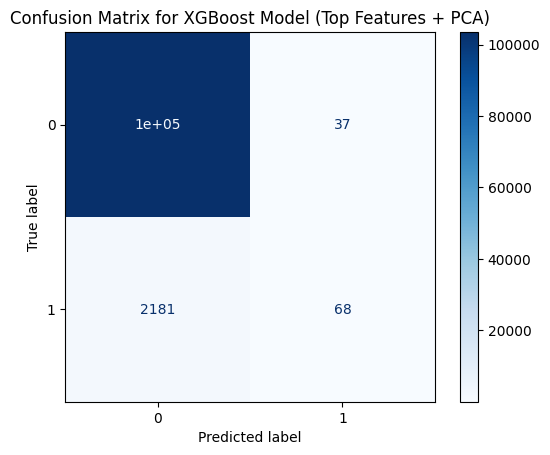

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Combine original top features and PCA components
X_combined = np.hstack([X_reduced, X_pca])

# Split the data
X_train_combined, X_test_combined, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb_model_combined = XGBClassifier()
xgb_model_combined.fit(X_train_combined, y_train)

# Generate predictions
y_pred_combined = xgb_model_combined.predict(X_test_combined)

# Calculate accuracy
accuracy_combined = accuracy_score(y_test, y_pred_combined)
print(f'Accuracy of XGBoost on combined data: {accuracy_combined:.4f}')

# Create and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_combined)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model_combined.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for XGBoost Model (Top Features + PCA)')
plt.show()

<p style="font-size:10px"> We then generated a variant of the XGBoost model that combined the 10 top features as well as the PCA components. A confusion matrix of the combined XGBoost model's performance shows that the model is very strong at correctly identifying fraudulent transactions (few false positives, and thus high precision). However, it is much weaker at identifying all of the fraudulent transactions in the dataset (high number of false negatives, and thus lower recall). </p>

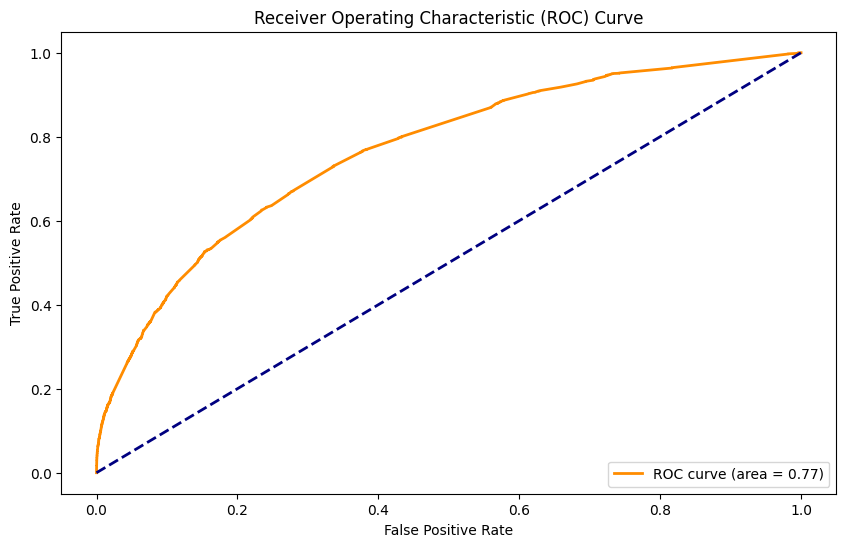

In [19]:
y_prob = xgb_model_combined.predict_proba(X_test_combined)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

<p style="font-size:10px"> The combined XGBoost model still had a ROC curve with an area of 0.77, indicating that it performed better than random guessing, but it was much weaker than the original XGBoost model (area = 0.90). </p>

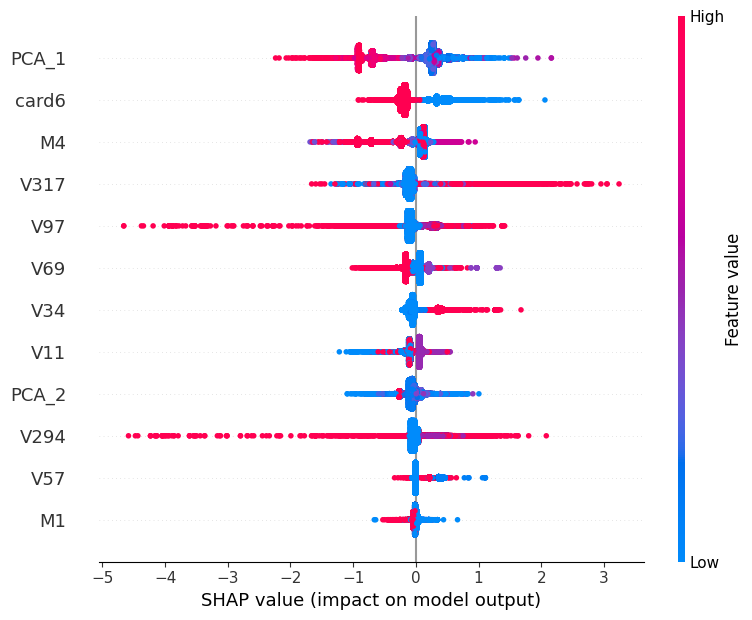

In [20]:
X_test_combined_df = pd.DataFrame(X_test_combined, columns=list(top_features) + ["PCA_1", "PCA_2"])

# Re-run the SHAP explainer with the DataFrame that includes column names
explainer = shap.TreeExplainer(xgb_model_combined)
shap_values = explainer.shap_values(X_test_combined_df)

# Summary plot with labeled features
shap.summary_plot(shap_values, X_test_combined_df)

<p style="font-size:10px"> To better understand our combined XGBoost model, we created a SHAP plot analyzing the impact of each feature (including the two PCA components) on the model output. </p>

# ----------------------------------------------------------------------------------

# Ensemble Method: Stacking + Blending (Don't Run)

In [21]:
estimators = [
    ('xgb', XGBClassifier()),
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('lr', LogisticRegression())
]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_model.fit(X_train_combined, y_train)

StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('rf', RandomForestClassifier()),
                               ('lr', LogisticRegression())],
                   final_estimator=LogisticRegression())

Accuracy: 0.9788
Precision: 0.5075
Recall: 0.0449
F1 Score: 0.0825
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    103525
           1       0.51      0.04      0.08      2249

    accuracy                           0.98    105774
   macro avg       0.74      0.52      0.54    105774
weighted avg       0.97      0.98      0.97    105774



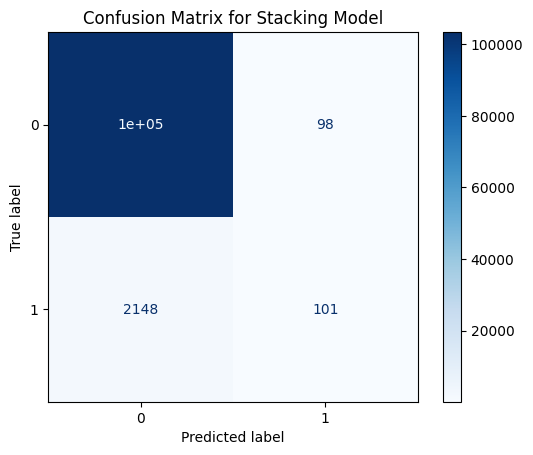

In [22]:
y_pred = stacking_model.predict(X_test_combined)
y_prob = stacking_model.predict_proba(X_test_combined)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=stacking_model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Stacking Model')
plt.show()

<p style="font-size:10px"> After trying several iterations of XGBoost and not being able to improve its performance, we moved on to try a stacking classifier which blends the output of 3 different classifiers (XGBoost, Random Forest, and Logistic Regression) before feeding the blended output to a Logistic Regression classifier. </p>

<p style="font-size:10px"> The resulting classifier had a lower precision but higher recall than the original XGBoost (0.51 vs. 0.79 for original XGBoost) and (0.51 vs. 0.25 for orgiinal XGBoost). </p>

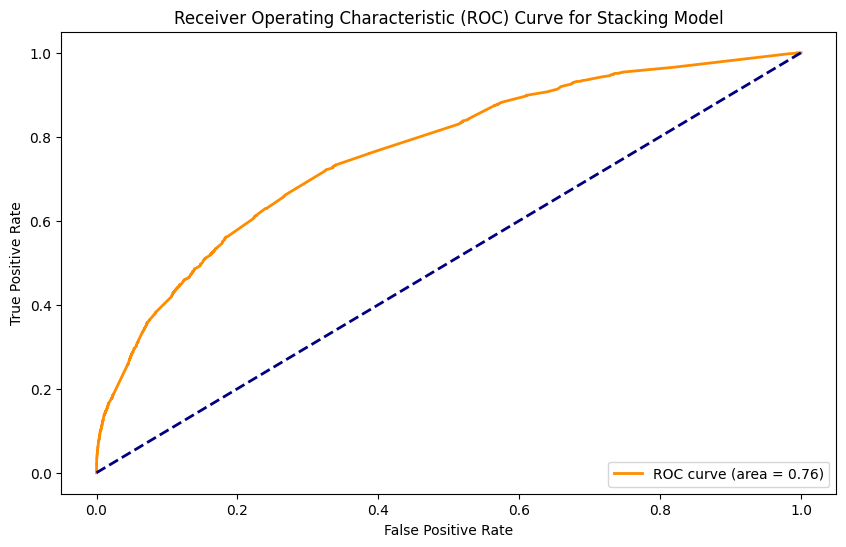

In [23]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Stacking Model')
plt.legend(loc='lower right')
plt.show()

<p style="font-size:10px"> The overall area under the ROC curve for the stacking model was lower than that of the original XGBoost (0.76 vs. 0.90 for the original model.) </p>

# ----------------------------------------------------------------------------------

# Voting Model (Don't Run)

In [24]:
voting_model = VotingClassifier(
    estimators=estimators,
    voting='soft',
    weights=[0.4, 0.3, 0.3]
)
weight_options = [
    [0.5, 0.3, 0.2],
    [0.6, 0.2, 0.2],
    [0.4, 0.4, 0.2],
    [0.3, 0.3, 0.4],
    [0.3, 0.4, 0.3],
    [0.7, 0.2, 0.1],
    [0.7, 0.1, 0.2]
]

best_score = 0
best_weights = None

# Iterate through different weight options
for weights in weight_options:
    voting_model.set_params(weights=weights)
    scores = cross_val_score(voting_model, X_train_combined, y_train, cv=5, scoring='accuracy')
    mean_score = scores.mean()
    if mean_score > best_score:
        best_score = mean_score
        best_weights = weights

print(f"Best Weights: {best_weights} with Accuracy: {best_score:.4f}")

Best Weights: [0.7, 0.2, 0.1] with Accuracy: 0.9786


<p style="font-size:10px"> To improve the performance of the stacking model, we tried finding the set of weights for the stacking model inputs that resulted in the highest accuracy. </p>

# ----------------------------------------------------------------------------------

# Repeated Nested Cross Validation (DON'T RUN THEY ARE FINISHED)

In [25]:
def calculate_multi_correlation(X, y):
    """
    Calculate the multi-correlation coefficient between features in X and the target y.
    """
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    corr_coefficients = mutual_info_classif(X_scaled, y, random_state=42)
    return corr_coefficients

## Lasso for Feature Selection (DONT RUN)

In [ ]:
outer_cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=42)
inner_cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=42)

# Models with Class Weights
xgb_model_2 = XGBClassifier(random_state=42, scale_pos_weight=(97 / 3))  # Adjust weights for XGBoost
#The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to
#class frequencies in the input data as n_samples / (n_classes * np.bincount(y))
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
lr_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=500)

num_features = 450
lower_bound_depth = int(np.floor(np.log2(num_features)))
upper_bound_depth = num_features
depth_range = [lower_bound_depth, lower_bound_depth + 2, int(upper_bound_depth / 2)]

# Parameter grid for RandomizedSearch
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': depth_range,
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

# Initialize lists to store metrics for each outer fold
outer_accuracy = []
outer_precision = []
outer_recall = []
outer_f1 = []
outer_roc_auc = []

# Outer Loop: Repeated Stratified Cross-Validation
for train_index, test_index in outer_cv.split(X_train, y_train):
    # Split Outer Training and Test Sets
    X_outer_train, X_outer_test = X_train.iloc[train_index], X_train.iloc[test_index]  # Use .iloc for indexing
    y_outer_train, y_outer_test = y_train.iloc[train_index], y_train.iloc[test_index]  # Use .iloc for indexing

    # SMOTE to Balance the Classes (Precomputed for efficiency)
    smote = SMOTE(random_state=42, n_jobs=-1)  # Parallel SMOTE if available
    X_outer_train, y_outer_train = smote.fit_resample(X_outer_train, y_outer_train)

    # Feature Selection Using SelectFromModel (faster than LassoCV)
    lasso = LassoCV(cv=inner_cv, random_state=42, n_jobs=-1).fit(X_outer_train, y_outer_train)  # Fewer inner folds
    selected_features = np.where(lasso.coef_ != 0)[0]

    # Use .iloc to select columns by index
    X_outer_train = X_outer_train.iloc[:, selected_features]
    X_outer_test = X_outer_test.iloc[:, selected_features]

    # Hyperparameter Tuning with RandomizedSearchCV (Reduce Iterations)
    random_search = RandomizedSearchCV(
        estimator=xgb_model_2,
        param_distributions=param_grid,
        n_iter=5,  # Fewer iterations
        scoring='accuracy',
        cv=inner_cv,  # Fewer inner CV folds
        n_jobs=-1,  # Utilize all cores
        random_state=42
    )
    random_search.fit(X_outer_train, y_outer_train)
    best_xgb_model = random_search.best_estimator_

    # Voting Classifier with Tuned XGB Model and Class-Weighted Models
    estimators = [
        ('xgb', best_xgb_model),
        ('rf', rf_model),
        ('lr', lr_model)
    ]
    voting_model = VotingClassifier(
        estimators=estimators,
        voting='soft',
        weights=[0.7, 0.2, 0.1],
        n_jobs=-1  # Parallel voting if supported
    )

    # Train the Voting Model on the Outer Training Set
    voting_model.fit(X_outer_train, y_outer_train)

    # Evaluate the Voting Model on the Outer Test Set
    y_pred = voting_model.predict(X_outer_test)
    y_prob = voting_model.predict_proba(X_outer_test)[:, 1]

    # Calculate Metrics
    outer_accuracy.append(accuracy_score(y_outer_test, y_pred))
    outer_precision.append(precision_score(y_outer_test, y_pred, zero_division=0))
    outer_recall.append(recall_score(y_outer_test, y_pred, zero_division=0))
    outer_f1.append(f1_score(y_outer_test, y_pred, zero_division=0))
    outer_roc_auc.append(roc_auc_score(y_outer_test, y_prob))

# Print Average Metrics Across All Outer Folds
print(f"Accuracy: {np.mean(outer_accuracy):.4f} ± {np.std(outer_accuracy):.4f}")
print(f"Precision: {np.mean(outer_precision):.4f} ± {np.std(outer_precision):.4f}")
print(f"Recall: {np.mean(outer_recall):.4f} ± {np.std(outer_recall):.4f}")
print(f"F1 Score: {np.mean(outer_f1):.4f} ± {np.std(outer_f1):.4f}")
print(f"ROC-AUC Score: {np.mean(outer_roc_auc):.4f} ± {np.std(outer_roc_auc):.4f}")

Accuracy: 0.0216 ± 0.0000
Precision: 0.0216 ± 0.0000
Recall: 1.0000 ± 0.0000
F1 Score: 0.0423 ± 0.0000
ROC-AUC Score: 0.5553 ± 0.0030


In [31]:
# Step 5: Final Model Training on the Entire Dataset
# The final voting model is trained on the entire dataset using the selected features
voting_model.fit(X_train.iloc[:, selected_features], y_train) # Use .iloc with integer position

# Step 6: Evaluate the Final Model on the Independent Test Set
# Apply the same feature selection to the independent test set
X_test_selected = X_test.iloc[:, selected_features] # Use .iloc with integer position
y_final_pred = voting_model.predict(X_test_selected)
y_final_prob = voting_model.predict_proba(X_test_selected)[:, 1]


# Calculate and print final metrics for the independent test set
final_accuracy = accuracy_score(y_test, y_final_pred)
final_precision = precision_score(y_test, y_final_pred)
final_recall = recall_score(y_test, y_final_pred)
final_f1 = f1_score(y_test, y_final_pred)
final_roc_auc = roc_auc_score(y_test, y_final_prob)

print(f"Final Model Accuracy: {final_accuracy:.4f}")
print(f"Final Model Precision: {final_precision:.4f}")
print(f"Final Model Recall: {final_recall:.4f}")
print(f"Final Model F1 Score: {final_f1:.4f}")
print(f"Final Model ROC-AUC Score: {final_roc_auc:.4f}")

Final Model Accuracy: 0.9526
Final Model Precision: 0.0400
Final Model Recall: 0.0534
Final Model F1 Score: 0.0457
Final Model ROC-AUC Score: 0.5695


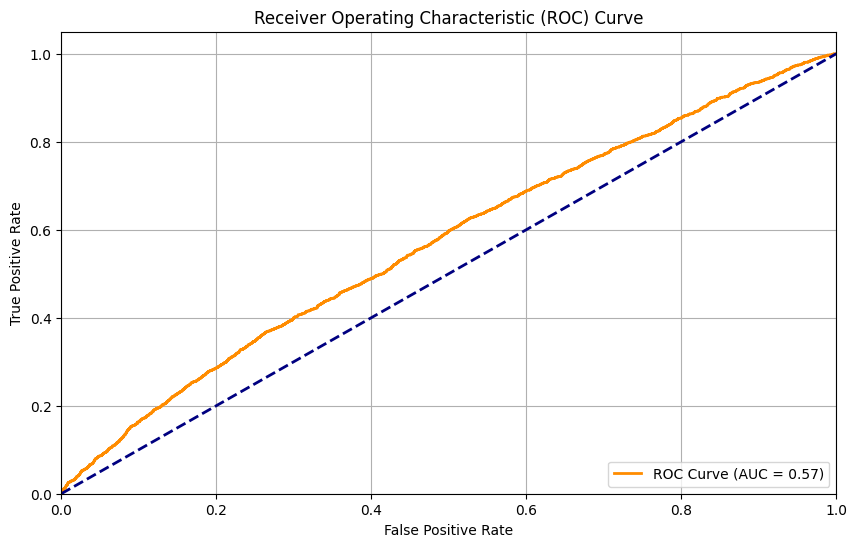

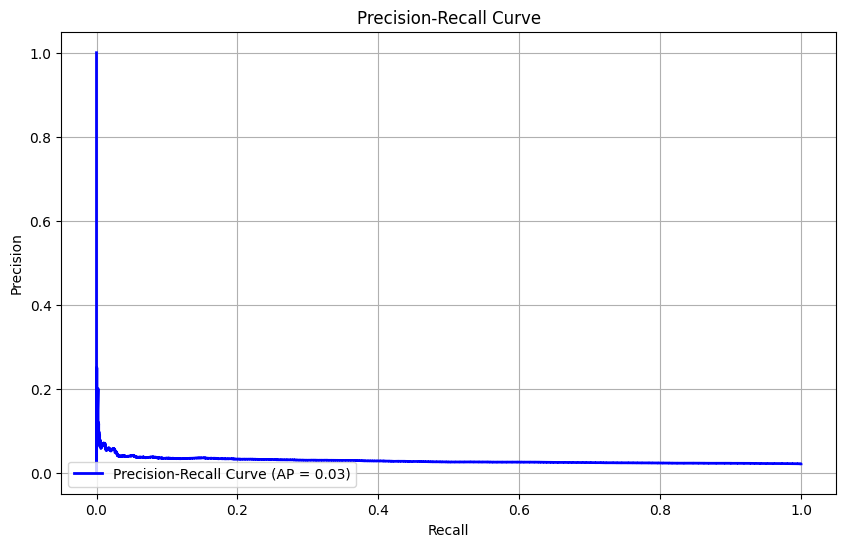

Average Precision Score: 0.0288


In [32]:
fpr, tpr, _ = roc_curve(y_test, y_final_prob)
roc_auc = auc(fpr, tpr)

# Step 2: Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Step 3: Compute Precision-Recall Curve and Average Precision Score
precision, recall, _ = precision_recall_curve(y_test, y_final_prob)
avg_precision = average_precision_score(y_test, y_final_prob)

# Step 4: Plot Precision-Recall Curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall Curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

# Step 5: Print Average Precision Score
print(f"Average Precision Score: {avg_precision:.4f}")

<p style="font-size:10px"> As a final method of improving the performance of the stacking model, we used Repeated Nested Cross-Validation to generate the most relevant features and best hyperparameters to use in the stacking model. When LASSO regression was used for feature selection, we compared the best features as selected using each combination of the outer and inner folds, totalling 36 folds in total (3 outer folds run twice, so 6 outer folds in total, with 3 inner folds run twice for each outer fold, for 6 x 6 = 36 folds). We also used those same 36 folds to generate the best hyperparameters for the XGBoost model. </p>

<p style="font-size:10px"> The performance of the resulting model was very weak, with very low precision and recall, meaning that few of the fraudulent transactions it found were actually fraudulent and few of the fraudulent transactions were found at all. As a result, the area under the ROC curve was only slightly higher than 0.5, meaning that the model performed only slightly better than random guessing. </p>

In [33]:
with open('/content/drive/My Drive/IEEE_dataset/voting_model_LASSO.pkl', 'wb') as f:
    pickle.dump(voting_model, f)

# Random Forest Feature Importance For Feature (DON'T RUN)




In [34]:
# Step 1: Define Outer and Inner Cross-Validation
outer_cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=42)
inner_cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=42)

# Step 2: Define Base Models with Class Weights
xgb_model_2 = XGBClassifier(random_state=42, scale_pos_weight=(97 / 3))  # Adjust weights for XGBoost
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')
lr_model = LogisticRegression(random_state=42, max_iter=500, class_weight='balanced')

# Define parameter grid for RandomizedSearch
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, 20],
    'learning_rate': [0.1],
    'subsample': [0.8]
}

# Initialize metrics storage for outer folds
outer_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': [], 'mcc': []}

# Step 3: Nested Cross-Validation Loop
for train_index, test_index in outer_cv.split(X_train, y_train):
    # Split outer training and test sets
    X_outer_train, X_outer_test = X_train.iloc[train_index], X_train.iloc[test_index]
    y_outer_train, y_outer_test = y_train.iloc[train_index], y_train.iloc[test_index]

    # Apply SMOTE to balance classes in the training set
    smote = SMOTE(random_state=42)
    X_outer_train, y_outer_train = smote.fit_resample(X_outer_train, y_outer_train)

    # Feature Selection: Use Random Forest Feature Importances
    rf_model.fit(X_outer_train, y_outer_train)
    feature_importances = rf_model.feature_importances_
    selected_features = np.argsort(feature_importances)[-50:]  # Select top 50 features
    selected_features = [X.columns[i] for i in selected_features]  # Convert to feature names

    # Reduce the training and test sets to selected features
    X_outer_train = X_outer_train[selected_features]
    X_outer_test = X_outer_test[selected_features]

    # Hyperparameter Tuning with RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=xgb_model_2,
        param_distributions=param_grid,
        n_iter=3,
        scoring='accuracy',
        cv=inner_cv,
        n_jobs=-1,
        random_state=42
    )
    random_search.fit(X_outer_train, y_outer_train)
    best_xgb_model = random_search.best_estimator_

    # Define the Voting Classifier
    estimators = [
        ('xgb', best_xgb_model),
        ('rf', rf_model),
        ('lr', lr_model)
    ]
    voting_model = VotingClassifier(estimators=estimators, voting='soft')

    # Train the voting model on the outer training set
    voting_model.fit(X_outer_train, y_outer_train)

    # Evaluate the voting model on the outer test set
    y_pred = voting_model.predict(X_outer_test)
    y_prob = voting_model.predict_proba(X_outer_test)[:, 1] if hasattr(voting_model, 'predict_proba') else None

    # Store metrics for each outer fold
    outer_metrics['accuracy'].append(accuracy_score(y_outer_test, y_pred))
    outer_metrics['precision'].append(precision_score(y_outer_test, y_pred, zero_division=0))
    outer_metrics['recall'].append(recall_score(y_outer_test, y_pred, zero_division=0))
    outer_metrics['f1'].append(f1_score(y_outer_test, y_pred, zero_division=0))
    if y_prob is not None:
        outer_metrics['roc_auc'].append(roc_auc_score(y_outer_test, y_prob))
    outer_metrics['mcc'].append(matthews_corrcoef(y_outer_test, y_pred))

# Print average metrics across all outer folds
for metric, values in outer_metrics.items():
    print(f"{metric.capitalize()}: {np.mean(values):.4f} ± {np.std(values):.4f}")

# Step 4: Final Model Training on the Entire Dataset
# Feature Selection
rf_model.fit(X_train, y_train)
final_feature_importances = rf_model.feature_importances_
selected_features_final = np.argsort(final_feature_importances)[-50:]
selected_features_final = [X.columns[i] for i in selected_features_final]

# Save Selected Features
with open('/content/drive/My Drive/IEEE_dataset/selected_features.pkl', 'wb') as f:
    pickle.dump(selected_features_final, f)

# Save Preprocessed Data
X_selected = X[selected_features_final]
preprocessed_data = {'X': X_selected, 'y': y}
with open('/content/drive/My Drive/IEEE_dataset/preprocessed_data.pkl', 'wb') as f:
    pickle.dump(preprocessed_data, f)

# Train Final Voting Model
X_train_selected = X_train[selected_features_final]
X_test_selected = X_test[selected_features_final]
voting_model.fit(X_train_selected, y_train)

# Evaluate Final Model
y_final_pred = voting_model.predict(X_test_selected)
y_final_prob = voting_model.predict_proba(X_test_selected)[:, 1] if hasattr(voting_model, 'predict_proba') else None

final_accuracy = accuracy_score(y_test, y_final_pred)
final_precision = precision_score(y_test, y_final_pred)
final_recall = recall_score(y_test, y_final_pred)
final_f1 = f1_score(y_test, y_final_pred)
final_roc_auc = roc_auc_score(y_test, y_final_prob) if y_final_prob is not None else None
final_mcc = matthews_corrcoef(y_test, y_final_pred)

print(f"Final Model Accuracy: {final_accuracy:.4f}")
print(f"Final Model Precision: {final_precision:.4f}")
print(f"Final Model Recall: {final_recall:.4f}")
print(f"Final Model F1 Score: {final_f1:.4f}")
print(f"Final Model MCC: {final_mcc:.4f}")
if final_roc_auc is not None:
    print(f"Final Model ROC-AUC Score: {final_roc_auc:.4f}")

# Save Final Metrics
final_metrics = {
    'accuracy': final_accuracy,
    'precision': final_precision,
    'recall': final_recall,
    'f1_score': final_f1,
    'roc_auc': final_roc_auc,
    'mcc': final_mcc
}
with open('/content/drive/My Drive/IEEE_dataset/final_metrics.pkl', 'wb') as f:
    pickle.dump(final_metrics, f)

# Save Final Model
with open('/content/drive/My Drive/IEEE_dataset/voting_model_rf.pkl', 'wb') as f:
    pickle.dump(voting_model, f)


Accuracy: 0.9600 ± 0.0046
Precision: 0.2155 ± 0.0259
Recall: 0.3124 ± 0.0132
F1: 0.2538 ± 0.0169
Roc_auc: 0.8053 ± 0.0058
Mcc: 0.2390 ± 0.0155
Final Model Accuracy: 0.9872
Final Model Precision: 0.9298
Final Model Recall: 0.4300
Final Model F1 Score: 0.5880
Final Model MCC: 0.6276
Final Model ROC-AUC Score: 0.9368


<p style="font-size:10px"> We also used Repeated Nested Cross-Validation with Random Forest for feature selection to generate the most relevant features and best hyperparameters to use in the stacking model. When Random Forest was used for feature selection, we compared the best features as selected using each of the outer (but not inner) folds, totalling 6 folds in total. We did use all of the outer and inner folds (totalling 36 folds) to generate the best hyperparameters for the XGBoost model. </p>

<p style="font-size:10px"> The performance of the resulting model was strong, with a much higher precision (0.93). The model had a recall of 0.43, which was relatively strong among the models we tried for this project, and an ROC-AUC score of 0.94, which was the highest of any of the models we tried. </p>

# ONE CLASS SVM CROSS-VALIDATION

In [35]:
#A basic rule of thumb is briefly covered in NTU's practical guide
#to support vector classification (Appendix C).
#If the number of features is large, one may not need to map
#data to a higher dimensional space. That is, the nonlinear mapping does
#not improve the performance. Using the linear kernel is good enough
#- https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf

from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.utils import resample
import numpy as np

# Initialize metrics storage for outer folds
outer_metrics_svm = {
    'accuracy': [], 'precision': [], 'recall': [],
    'f1': [], 'roc_auc': [], 'multi_corr': []
}

# List to store models for each fold
svm_models = []

# Outer Cross-Validation
outer_cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=42)

# Apply PCA to reduce dimensions globally (if needed)
pca = PCA(n_components=50)  # Keep top 50 components
X_train_pca = pca.fit_transform(X_train)

# Outer Loop for Cross-Validation
for train_index, test_index in outer_cv.split(X_train_pca, y_train):
    # Split Outer Training and Test Sets
    X_outer_train, X_outer_test = X_train_pca[train_index], X_train_pca[test_index]
    y_outer_train, y_outer_test = y_train.iloc[train_index], y_train.iloc[test_index]


    # Subsample Majority Class (Non-Fraud) for Training
    X_train_majority = X_outer_train[y_outer_train == 0]  # Retain non-fraud
    X_train_majority = resample(X_train_majority, n_samples=50000, random_state=42)  # Subsample to 50,000 samples

    # Train One-Class SVM
    one_class_svm = OneClassSVM(kernel='rbf', nu=0.1, gamma='scale')
    one_class_svm.fit(X_train_majority)

    # Store the trained model
    svm_models.append(one_class_svm)

    # Predict Anomalies on the Test Set
    y_pred_scores = one_class_svm.decision_function(X_outer_test)  # Higher = more normal
    y_pred = one_class_svm.predict(X_outer_test)

    # Convert One-Class SVM predictions to binary labels
    y_pred_binary = (y_pred == -1).astype(int)  # Convert -1 to 1 (fraud)

    # Calculate Multi-Correlation Coefficient
    multi_corr = calculate_multi_correlation(X_outer_test, y_outer_test)
    outer_metrics_svm['multi_corr'].append(np.mean(multi_corr))  # Store average multi-correlation

    # Evaluate Performance
    accuracy = accuracy_score(y_outer_test, y_pred_binary)
    precision = precision_score(y_outer_test, y_pred_binary, zero_division=0)
    recall = recall_score(y_outer_test, y_pred_binary, zero_division=0)
    f1 = f1_score(y_outer_test, y_pred_binary, zero_division=0)
    roc_auc = roc_auc_score(y_outer_test, y_pred_scores)

    # Store metrics
    outer_metrics_svm['accuracy'].append(accuracy)
    outer_metrics_svm['precision'].append(precision)
    outer_metrics_svm['recall'].append(recall)
    outer_metrics_svm['f1'].append(f1)
    outer_metrics_svm['roc_auc'].append(roc_auc)

# Print average metrics across all outer folds
print("One-Class SVM Metrics:")
for metric, values in outer_metrics_svm.items():
    print(f"{metric.capitalize()}: {np.mean(values):.4f} ± {np.std(values):.4f}")


One-Class SVM Metrics:
Accuracy: 0.8822 ± 0.0014
Precision: 0.0242 ± 0.0010
Recall: 0.1135 ± 0.0064
F1: 0.0399 ± 0.0018
Roc_auc: 0.4600 ± 0.0033
Multi_corr: 0.0020 ± 0.0001


<p style="font-size:10px"> Finally, we tried a support vector machine (SVM) with cross-validation model for fraud detection, but the performance was extremely weak. The AUC for the ROC curve was less than 0.5, implying that the model was worse than random guessing. </p>

In [36]:
model_path = '/content/drive/My Drive/IEEE_dataset/one_class_svm_models.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(svm_models, f)